<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

6    2347
4    2131
1    2013
3    1809
0    1788
2    1316
5    1063
7     877
Name: state, dtype: int64

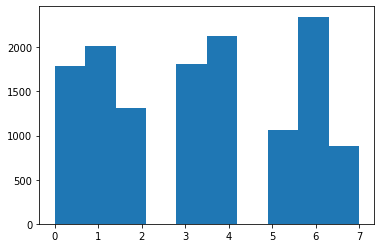

In [7]:
plt.hist(states.state);

In [8]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6, 7]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

0

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1972, 12, 6),
 datetime.date(2022, 11, 24),
 datetime.date(2012, 11, 24),
 5)

In [13]:
START, TODAY

(datetime.date(1972, 12, 6), datetime.date(2022, 11, 24))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def get_annualized_daily_return(returns):
    #s_returns = returns[data.state == 0]
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    amt = returns.cumprod()
    n = len(returns)
    daily_return = amt[-1]**(1/max(n - 1, 1))
    return daily_return

In [22]:
def get_daily_annualized_return_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state])
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [23]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [24]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data)
    return state_dars

In [25]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_15614/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_15614/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


IVR JMSB KERX KRMD LCA LIN LPI LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_15614/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


NYXH OLLI ORCL PACX PCX PGHD PLL POWW PSAG PXMD RADI RENT RLTY RRI SAGA SCLN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_15614/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE YDKN ZOM 

In [26]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7
A,1.000303,0.995580,1.000880,1.000371,1.000925,1.000000,1.002646,1.001828,1.014296
AA,1.000266,0.994281,1.000723,1.000978,1.000915,1.001789,1.001692,1.000913,1.000729
AAIC,0.999503,0.992920,1.001123,1.000037,1.001077,1.000000,1.001514,1.000046,1.014072
AAL,0.999946,0.993749,0.999617,1.002538,1.001022,1.000000,1.000513,1.002015,1.020841
AAME,0.999985,0.996399,1.000105,1.001028,1.000762,1.001108,1.000504,1.000050,1.002056


In [27]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7
ZTEK,1.000549,0.998952,0.998134,1.000265,1.004644,1.000000,1.002259,0.998869,1.012678
ZTR,1.000197,0.998373,1.000174,1.000383,1.000722,1.000731,1.000617,1.000644,1.000514
ZUMZ,1.000153,0.995596,0.999927,1.001350,1.000922,1.000000,1.001060,1.001708,1.006046
ZWS,1.000082,0.993462,1.001184,0.997650,1.001344,1.000000,1.002192,1.001225,1.017342
ZYXI,1.000504,0.998226,1.001480,1.001170,0.998167,1.000000,0.999752,1.002807,1.030403


In [28]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [29]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [30]:
CURRENT_STATE# = 0

0

In [31]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]


if CURRENT_STATE == 0:
    df['weighted'] = (
        0.7*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df.dar)
elif CURRENT_STATE == 1:
    df['weighted'] = (
        0.6*df[f'dar_{CURRENT_STATE}']
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.1*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
#elif CURRENT_STATE == ...
elif CURRENT_STATE == 7:
    df['weighted'] = (
        0.3*df[f'dar_{CURRENT_STATE}']
        + 0.5*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7,weighted
ELC,1.001287,1.006616,1.000757,0.997031,1.000701,1.0,1.001800,1.000842,0.989877,1.004964
AMEH,1.000327,1.004138,0.993703,1.004024,1.004337,1.0,0.995327,1.002204,1.008831,1.002332
BYRN,1.000247,1.002396,0.995580,0.999945,1.001691,1.0,0.998950,1.003995,1.008661,1.001284
MICS,0.999229,1.001814,1.001545,0.996379,0.997639,1.0,0.998637,0.997321,1.003549,1.001270
FSI,1.001280,1.000817,1.002442,1.000127,1.001067,1.0,1.001431,1.000769,1.019440,1.001072


In [32]:
df.mean(), df.median()

(dar         1.000175
 dar_0       0.996490
 dar_1       1.000350
 dar_2       1.000644
 dar_3       1.000992
 dar_4       1.000351
 dar_5       1.001249
 dar_6       1.000882
 dar_7       1.007120
 weighted    0.997612
 dtype: float64,
 dar         1.000269
 dar_0       0.996660
 dar_1       1.000428
 dar_2       1.000693
 dar_3       1.001013
 dar_4       1.000000
 dar_5       1.001206
 dar_6       1.000876
 dar_7       1.005236
 weighted    0.997763
 dtype: float64)

In [33]:
always_exclude = ['NXN', 'NXP']
exclude = {
    0: ['ABST', 'AGI', 'APT', 'CZFS', 'ELC', 'ESOA', 'FSI', 'GCBC', 'GME', 'IPB', 'RNR', 'WTRG'],
    1: ['CTSH', 'ELC', 'MOBQ', 'TSLA'],
    7: ['ELC']}

In [34]:
best_weighted = [
    s for s in df.index if s not in exclude[CURRENT_STATE] + always_exclude
][:20]

In [35]:
print(sorted(best_weighted))

['ABST', 'AMEH', 'BYRN', 'CEF', 'CGAU', 'CIZN', 'CTGO', 'DYAI', 'FNV', 'HMY', 'HNRG', 'IEI', 'MICS', 'MICT', 'MMU', 'MNP', 'MTA', 'MUE', 'NAN', 'OMQS']


In [36]:
df.loc[best_weighted]

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7,weighted
AMEH,1.000327,1.004138,0.993703,1.004024,1.004337,1.000,0.995327,1.002204,1.008831,1.002332
BYRN,1.000247,1.002396,0.995580,0.999945,1.001691,1.000,0.998950,1.003995,1.008661,1.001284
MICS,0.999229,1.001814,1.001545,0.996379,0.997639,1.000,0.998637,0.997321,1.003549,1.001270
MTA,1.000482,1.001512,0.999099,1.000301,0.999204,1.000,1.001522,1.001396,0.971169,1.001065
MICT,0.999783,1.001923,0.997356,0.999509,1.000802,1.000,0.999331,0.999933,1.014219,1.001038
HNRG,1.000223,1.001477,0.998844,1.002675,1.000381,1.000,0.998950,1.000153,1.006389,1.000963
OMQS,0.999801,1.001301,1.000616,1.004440,0.994640,1.000,1.001215,0.998955,0.985001,1.000933
HMY,0.999991,1.000810,1.000457,0.999244,0.999302,1.000,0.999327,0.999975,1.005216,1.000611
CGAU,1.000017,1.000704,1.000368,0.999720,1.000609,1.000,0.999862,0.999023,0.985726,1.000533
FNV,1.000649,1.000370,1.000791,1.001440,1.000466,1.000,1.000605,1.000416,0.996887,1.000468


In [37]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [38]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,ABST,AMEH,BYRN,CEF,CGAU,CIZN,CTGO,DYAI,FNV,HMY,HNRG,IEI,MICS,MICT,MMU,MNP,MTA,MUE,NAN,OMQS
Date,,,,,,,,,,,,,,,,,,,,
2022-11-17,9.32,30.120001,8.14,16.900000,5.08,14.00,23.76,1.80,136.429993,3.32,8.13,115.070000,4.67,0.92,9.99,11.85,4.95,10.03,10.49,5.92
2022-11-18,9.44,30.120001,8.26,16.820000,5.11,14.00,23.76,1.92,138.789993,3.34,8.02,114.769997,5.07,0.94,10.09,11.78,4.96,10.04,10.51,5.49
2022-11-21,9.34,28.280001,8.26,16.730000,5.02,14.00,23.76,1.83,137.190002,3.37,7.94,114.730003,5.07,0.95,10.17,11.88,4.74,10.19,10.69,5.25
2022-11-22,9.73,28.129999,8.20,16.870001,5.29,14.00,23.60,1.74,143.360001,3.51,8.68,114.940002,4.65,1.05,10.26,11.92,5.06,10.28,10.89,5.05
2022-11-23,10.20,29.020000,8.20,17.080000,5.40,13.95,23.60,1.74,144.500000,3.57,9.14,115.279999,4.70,1.21,10.22,11.94,5.19,10.26,10.91,5.07


In [39]:
data = pd.concat([data, states], axis=1)

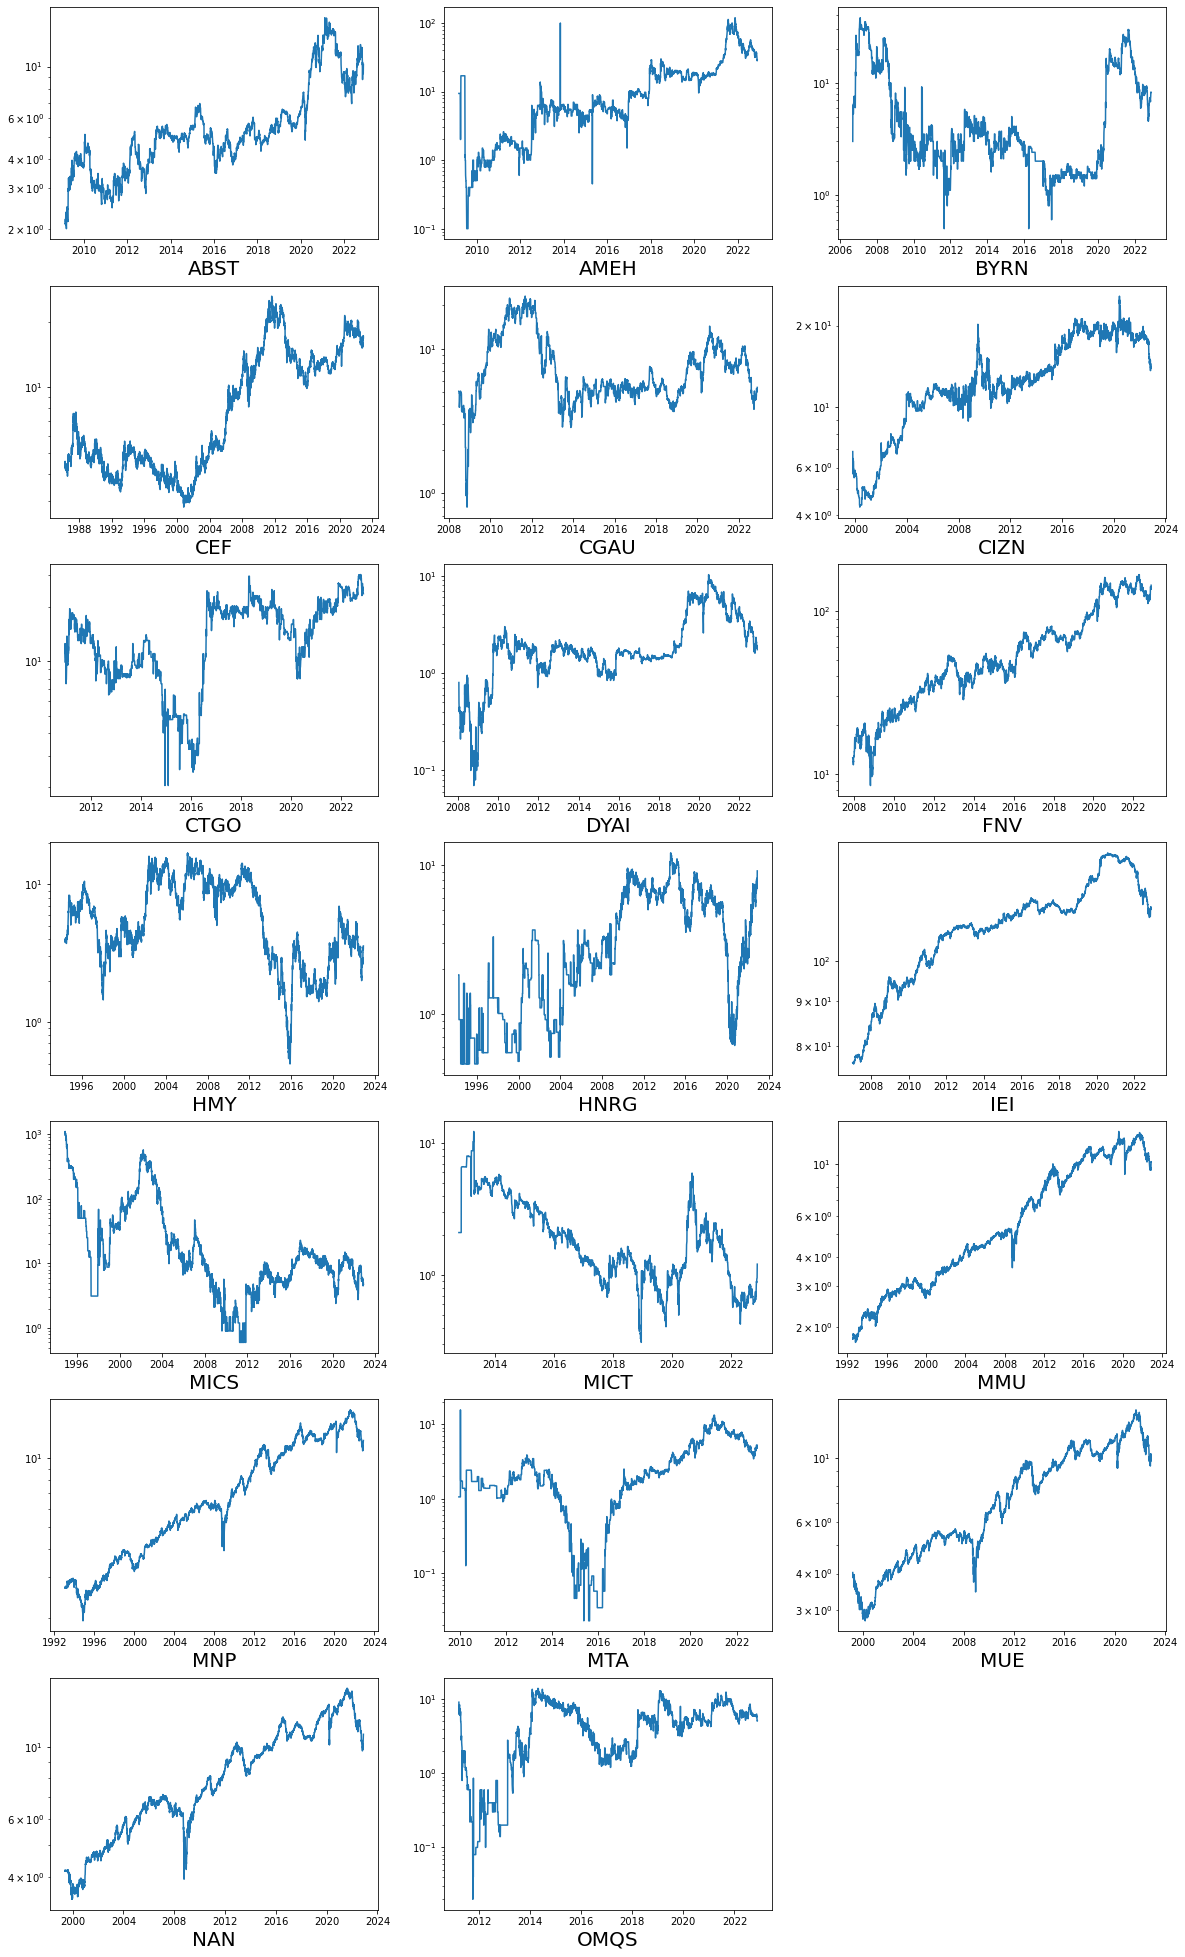

In [40]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

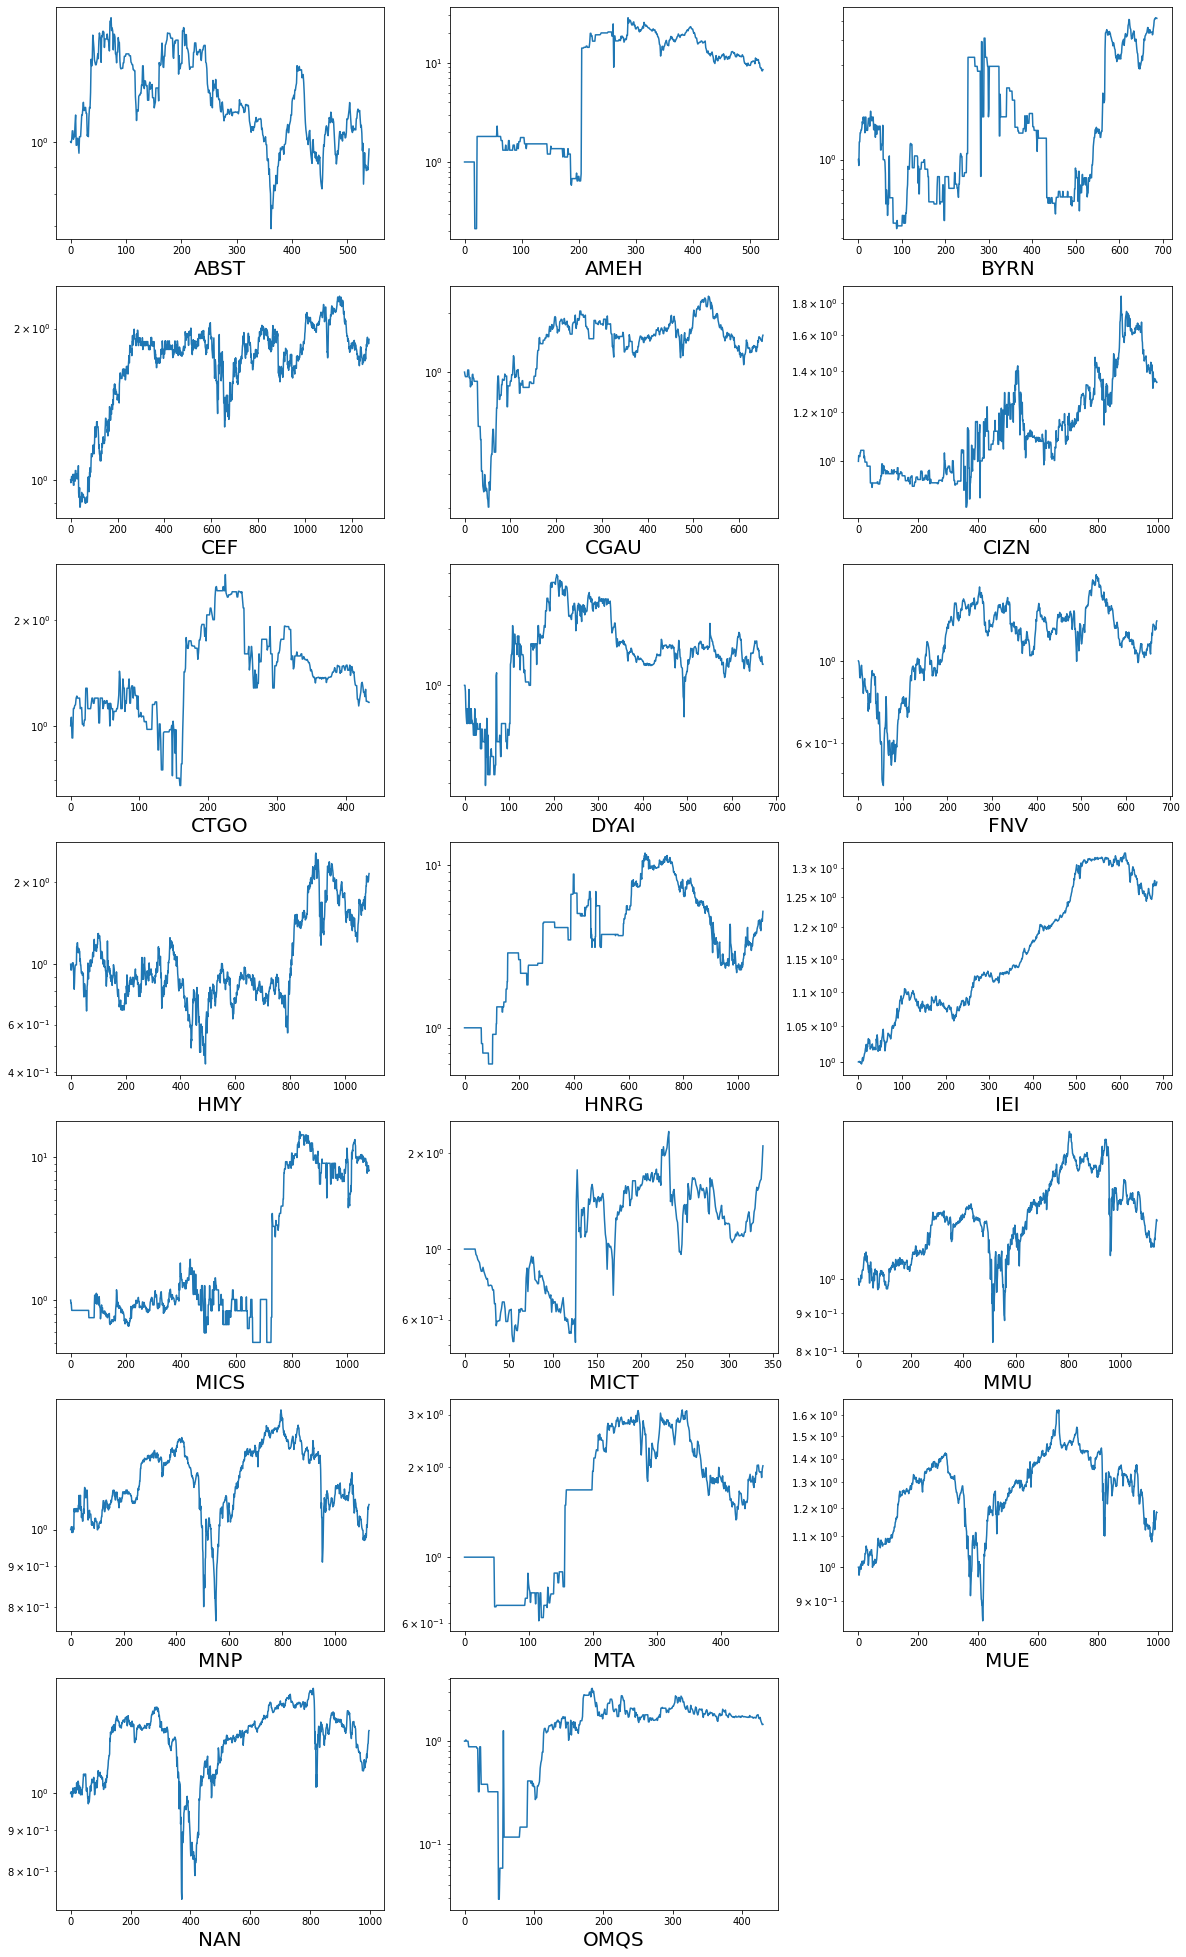

In [41]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.yscale('log')
    plt.xlabel(sym);